### winedata 불러오기

In [3]:
import pandas as pd

wine_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/'+"master/dataset/wine.csv"

wine = pd.read_csv(wine_url, index_col=0)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### 맛 등급 만들어 넣기

In [4]:
wine['taste'] = [1. if grade>5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

### 데이터 분리

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =13)

### 간단하게 로지스틱 회귀 테스트

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# liblinear 최소값 찾을때
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print(accuracy_score(y_train, y_pred_tr))
print(accuracy_score(y_test, y_pred_test))

0.7427361939580527
0.7438461538461538


### StandardSclaer 적용해서 파이프라인 구축

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('scaler', StandardScaler()),
             ('clf', LogisticRegression(solver='liblinear', random_state=13))]

pipe = Pipeline(estimators)


In [8]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=13,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Ssaler의 상승효과가 있긴하다

In [9]:
y_pred_tr = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(accuracy_score(y_train, y_pred_tr))
print(accuracy_score(y_test, y_pred_test))

0.7444679622859341
0.7469230769230769


### Decision Tree와의 비교를 위한 작업

In [11]:
from sklearn.tree import DecisionTreeClassifier

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)
wine_tree.fit(X_train, y_train)

models = {'logistic regression':pipe, "decision tree":wine_tree}


### AUC 그래프를 이용한 모델간 비교

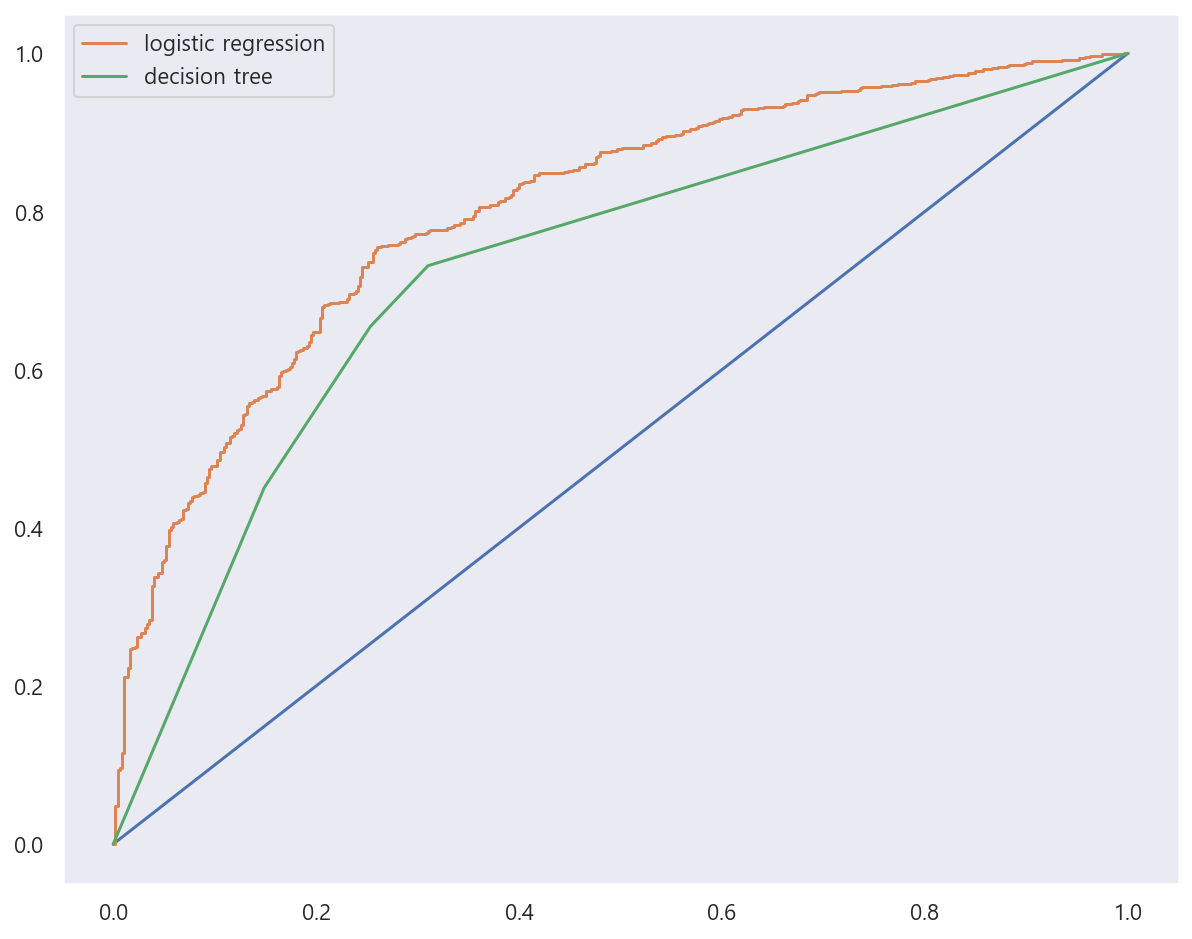

In [12]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
plt.plot([0,1],[0,1])
for model_name, model in models.items():
    pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label=model_name)
    
    
plt.grid()
plt.legend()
plt.show()

## PIMA 인디언 당뇨병 예측문제

### 데이터 불러오기

In [32]:
PIMA_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/diabetes.csv'

PIMA = pd.read_csv(PIMA_url)
PIMA.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [33]:
PIMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 먼저 상관관계 확인

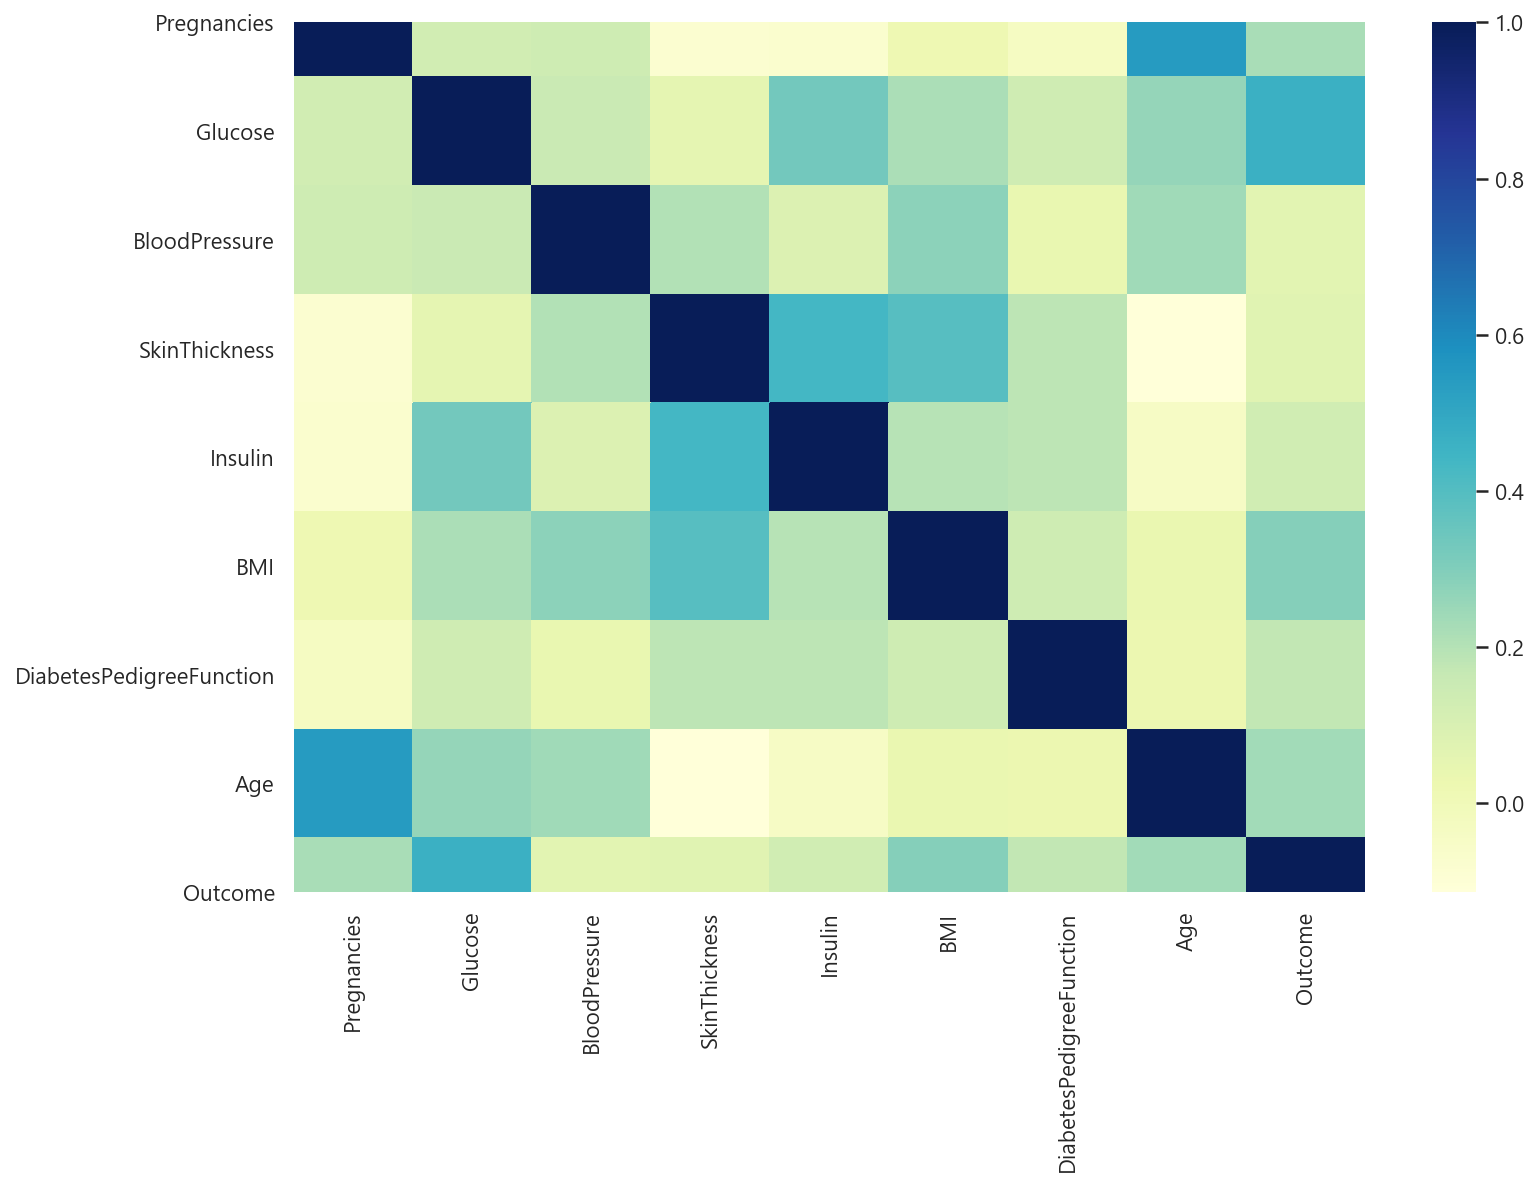

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(PIMA.corr(), cmap="YlGnBu")
plt.show()

### 0있는 데이터 확인

In [37]:
(PIMA==0).astype(int).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 의학적 지식과 PIMA 인디언에 대한 정보가 없으므로 일단 평균값으로 대체

In [38]:
zero_features = ["Glucose", 'BloodPressure', 'SkinThickness', 'BMI']
PIMA[zero_features] = PIMA[zero_features].replace(0, PIMA[zero_features].mean())
(PIMA==0).astype(int).sum()


Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 데이터를 나누고

In [44]:
from sklearn.model_selection import train_test_split

X = PIMA.drop(['Outcome'], axis=1)
y = PIMA['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state =13,
                                                    stratify = y)

### Pipeline을 만들고

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('scaler', StandardScaler()),
             ('clf', LogisticRegression(solver="liblinear", random_state=13))]

pipe_lr = Pipeline(estimators)
pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_test)


### 결과들을 확인 해보자

In [46]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score, roc_auc_score, f1_score)

print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))
print(roc_auc_score(y_test, pred))
print(f1_score(y_test, pred))

0.7727272727272727
0.6111111111111112
0.7021276595744681
0.7355555555555556
0.6534653465346535


### 다변수 방정식의 각 계수값을 확인할 수 있다

In [47]:
coeff = list(pipe_lr['clf'].coef_[0])
labels = list(X_train.columns)

In [48]:
coeff

[0.35426588844126494,
 1.201424442503758,
 -0.1584013553628671,
 0.03394657712929949,
 -0.16286471953988121,
 0.620404521989511,
 0.36669355795578734,
 0.17195965447035097]

### 중요한 feature에 대해 그려보자

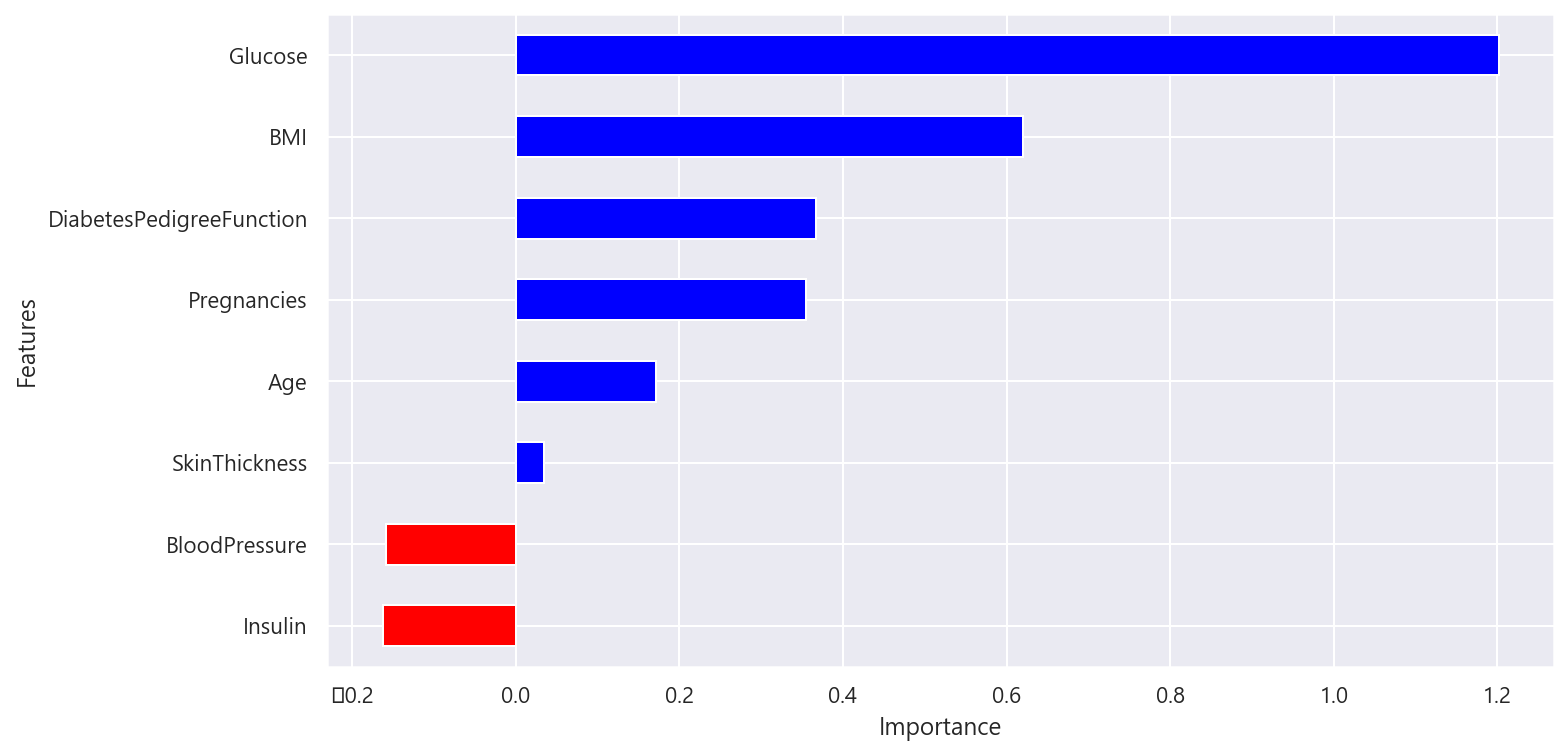

In [50]:
features = pd.DataFrame({'Features':labels, 'importance':coeff})
features.sort_values(by=['importance'], ascending=True, inplace=True)

features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features['importance'].plot(kind='barh',
                           figsize=(11,6),
                           color=features['positive'].map({True:'blue',
                                                          False:'red'}))

plt.xlabel('Importance')
plt.show()